In [1]:
from nupack import *
import numpy as np
import matplotlib.pyplot as plt
from Bio.SeqUtils import MeltingTemp as mt
from se_design.sequence_optimization_functions import load_ensemble, get_compseq
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm


In [2]:
def create_tube(seq, temp, my_model, c_seq=None):
    if c_seq is None:
        seqs = [seq, get_compseq(seq)]
    else:
        seqs = [seq, c_seq]
        
    strands = [Strand(seq, name=seq) for seq in seqs]

    c1 = Complex([strands[0]]) 
    c2 = Complex([strands[1]])
    c3 = Complex([strands[0], strands[1]])

    t1 = Tube(strands={strands[0]: 1e-8, strands[1]: 1e-8}, complexes=SetSpec(include=[c1, c2, c3]), name=f'{seq}')

    return t1


def get_unbound_fraction(all_seqs, temp, c_seq=None):
    my_model = Model(material='dna', celsius=temp, sodium=0.05, magnesium=0.0125)
    
    all_tubes = []
    
    if c_seq is None:
        for seq in all_seqs:
            all_tubes.append(create_tube(seq, temp, my_model))
    else:
        for seq, c_s in zip(all_seqs, c_seq):     
            all_tubes.append(create_tube(seq, temp, my_model, c_seq=c_s))   
    
    tube_results = tube_analysis(tubes=all_tubes, model=my_model)
    
    unbound_fraction = []
    for tube in tube_results.fields[0].values():
        concs = tube.complex_concentrations
        names = [c.name for c in concs]
        bound = 0
        unbound = 0
        for conc, name in zip(concs, names):
            name_split = name.split('+')
            if len(name_split) > 1:
                bound += concs[conc]
            else:
                unbound += concs[conc]
        unbound /= 2
        unbound_fraction.append(unbound / (unbound + bound))
        
    return unbound_fraction


def compute_melting_temp(all_seqs, temp_range=np.linspace(1,100,1), c_seq=None):
    unbound_fractions = {seq: [] for seq in all_seqs}
    
    for temp in temp_range:
        seq_wise_fractions = get_unbound_fraction(all_seqs, temp, c_seq=c_seq)
        for seq, frac in zip(all_seqs, seq_wise_fractions):
            unbound_fractions[seq].append(frac)
            
    melting_temperatures = {}
    for seq, all_fracs in unbound_fractions.items():
        melt = temp_range[np.abs(np.array(all_fracs) - 0.5).argmin()]
        melting_temperatures[seq] = melt
        
    return melting_temperatures, unbound_fractions


def seq_check(seq):
    
    # complocal = get_compseq(seq)
    # if complocal == seq: # don't want homopolymers 
    #     return 0
    
    if 'AAAA' in seq or 'TTTT' in seq or 'GGGG' in seq or 'CCCC' in seq:
        return 0
    elif 'AAAAA' in seq or 'TTTTT' in seq or 'GGGGG' in seq or 'CCCCC' in seq:
        return 0
    elif 'AAAAAA' in seq or 'TTTTTT' in seq or 'GGGGGG' in seq or 'CCCCCC' in seq:
        return 0
    elif 'AAA' in seq or 'TTT' in seq or 'GGG' in seq or 'CCC' in seq:  #newly added 
        return 0
    # elif 'A' == seq[0] or 'T' == seq[0] or 'A' == seq[-1] or 'T' == seq[-1]: #newly added 
    #     return 0
    elif 'A' not in seq or 'T' not in seq or 'G' not in seq or 'C' not in seq:
        return 0 
    # elif seq[0]=='G' or seq[0]=='C' or seq[-1]=='G' or seq[-1]=='G':
    #     return 1
    else:
        return 1 

In [3]:
path = '/scratch/matthew/project_files/SEdesign/sticky_end_libraries/raw_lib/'
all_files = [path + sys for sys in os.listdir(path) if sys.endswith('.txt')]

seq_input = [load_ensemble(candidate_sequences_file) for candidate_sequences_file in all_files]
seq_input = [inner for outer in seq_input for inner in outer]

len(seq_input)

195072

In [48]:
seqs_input_temp = []
for seq in seq_input:
    if seq not in seqs_input_temp:
        seqs_input_temp.append(get_compseq(seq))

print(len(seqs_input_temp))



In [78]:
print(len(seqs_input_temp))


97536


In [79]:
seqs_input_temp = [seq for seq in seqs_input_temp if seq_check(seq) == 1]
print(len(seqs_input_temp))

56286


In [51]:
# temp = 30
# unbound_fraction = get_unbound_fraction(seqs_input_temp, temp)

# temp_correct_seqs = {}
# for seq, frac in zip(seqs_input_temp, unbound_fraction):
#     value = frac
#     if (value > 0.49) and (value < 0.51):
#         temp_correct_seqs[seq] = value
# print(len(temp_correct_seqs))

1482


In [98]:
target_temp = 30
temp_correct_seqs = {}
for seq in seqs_input_temp:
    temp = mt.Tm_NN(seq, dnac1=10, dnac2=10, 
                    Na=50, K=0, Tris=0, Mg=12.5,
                    dNTPs=0, saltcorr=7)
    if (temp > target_temp - 0.1) and (temp < target_temp + 0.1):
        temp_correct_seqs[seq] = temp

In [99]:
len(temp_correct_seqs)

597

In [100]:
temp_range = np.linspace(20,40,21)

all_seqs = list(temp_correct_seqs.keys())

melting_temperatures, unbound_fractions = compute_melting_temp(all_seqs, temp_range=temp_range)

final_candidate = {}
for seq, temp in melting_temperatures.items():
    if (temp > 29) and (temp < 31):
        final_candidate[seq] = temp

print(len(final_candidate))

63


In [101]:
final_check = {}
for key in list(final_candidate.keys()):
    final_check[key] = temp_correct_seqs[key]
    
final_check

{'CGGCAATGT': 29.943131277746602,
 'CGCCGTTAA': 29.984148474756296,
 'CCGCATTGT': 29.943131277746716,
 'CGCGGTTAA': 29.984148474756296,
 'TGCCGAAGA': 30.082276706882453,
 'AGCTGGCTT': 29.99939007802334,
 'ACCACGTGA': 29.939564690194516,
 'ACGATCGGT': 29.900232858051538,
 'ACTGCGGAT': 30.020851903387154,
 'CGCCACATT': 29.943131277746716,
 'AATGCCACG': 29.943131277746602,
 'TGGTGCACT': 30.062043249430587,
 'ATCGCAGGT': 30.020851903387097,
 'CGGCATTGT': 29.943131277746716,
 'TGTATGCGC': 29.964326218656822,
 'TTCGGTCGA': 29.961498602622953,
 'AGCCTGCTT': 29.99939007802334,
 'ACACGTGGA': 29.93956469019446,
 'AACATGCCG': 29.943131277746602,
 'AAGGCTGCT': 29.99939007802334,
 'ATTGCACCG': 29.943131277746602,
 'ACACGTTCG': 30.080456377769394,
 'AACCGCATG': 29.943131277746716,
 'ACCGTGTGA': 29.93956469019446,
 'TTCGGACGA': 29.961498602623067,
 'TTCAACGCC': 29.96340339845699,
 'AGCTGCCTT': 29.99939007802334,
 'ATGGCGACT': 30.020851903387097,
 'ATGCAACGG': 29.943131277746602,
 'TCTTCCGCA': 30.0822

In [91]:
melting_temperatures

{'AGATTGCGC': np.float64(31.0),
 'GTCGCAACA': np.float64(29.0),
 'ACGTCATGC': np.float64(29.0),
 'TTCGAGCCA': np.float64(33.0),
 'ATGACACGC': np.float64(30.0),
 'GTGCTTGCA': np.float64(25.0),
 'TTCGCGAAG': np.float64(28.0),
 'CGTGCCATT': np.float64(28.0),
 'TGCGCCTAT': np.float64(35.0),
 'CGGCAATGT': np.float64(30.0),
 'TTCTCGCCA': np.float64(33.0),
 'TCTGACGCT': np.float64(32.0),
 'TGACAACGC': np.float64(30.0),
 'TGCTGAACG': np.float64(28.0),
 'ATCTCGCGA': np.float64(28.0),
 'AGTAACGCG': np.float64(29.0),
 'AGGCGTCAT': np.float64(32.0),
 'CGTTGAGCA': np.float64(28.0),
 'AGCTGCAAC': np.float64(30.0),
 'TGCATCGTG': np.float64(30.0),
 'TGAGAGCGT': np.float64(32.0),
 'ACCTCGCAT': np.float64(33.0),
 'GCGATCGAA': np.float64(27.0),
 'ACGCTGTCT': np.float64(32.0),
 'GACGCATGT': np.float64(28.0),
 'AGACGGCTT': np.float64(31.0),
 'TCGCAGTCA': np.float64(32.0),
 'ACATGTCGC': np.float64(29.0),
 'ACATGCAGC': np.float64(29.0),
 'ACTGCCGAT': np.float64(32.0),
 'TGCATCACG': np.float64(28.0),
 'ACGAGG

(array([125.,   0.,   0.,   0.,   0.,   0.,  43.,   0.,   0.,   0.,   0.,
          0.,  48.,   0.,   0.,   0.,   0.,   0.,  44.,   0.,   0.,   0.,
          0.,   0.,   0.,  64.,   0.,   0.,   0.,   0.,   0., 114.,   0.,
          0.,   0.,   0.,   0., 249.,   0.,   0.,   0.,   0.,   0., 372.,
          0.,   0.,   0.,   0.,   0.,   0., 531.,   0.,   0.,   0.,   0.,
          0., 420.,   0.,   0.,   0.,   0.,   0., 314.,   0.,   0.,   0.,
          0.,   0., 258.,   0.,   0.,   0.,   0.,   0.,   0., 211.,   0.,
          0.,   0.,   0.,   0., 178.,   0.,   0.,   0.,   0.,   0.,  44.,
          0.,   0.,   0.,   0.,   0.,  33.,   0.,   0.,   0.,   0.,   0.,
         46.]),
 array([20.  , 20.16, 20.32, 20.48, 20.64, 20.8 , 20.96, 21.12, 21.28,
        21.44, 21.6 , 21.76, 21.92, 22.08, 22.24, 22.4 , 22.56, 22.72,
        22.88, 23.04, 23.2 , 23.36, 23.52, 23.68, 23.84, 24.  , 24.16,
        24.32, 24.48, 24.64, 24.8 , 24.96, 25.12, 25.28, 25.44, 25.6 ,
        25.76, 25.92, 26.08, 26.24

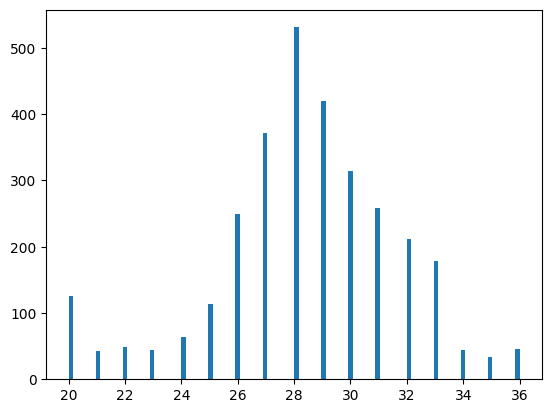

In [89]:
plt.hist(list(melting_temperatures.values()), bins=100)

In [102]:
with open('seq_candidiate_30c_1.txt', 'w') as f:
    for key, value in final_candidate.items():
        f.write(f'{key}\n')

In [29]:
seq = 'TTTTTTTTTTTTTTTTTTTTTTGGAGAGCGT'
Strand(seq, name=seq)

<Strand TTTTTTTTTTTTTTTTTTTTTTGGAGAGCGT>

Text(0, 0.5, 'Unbound Fraction')

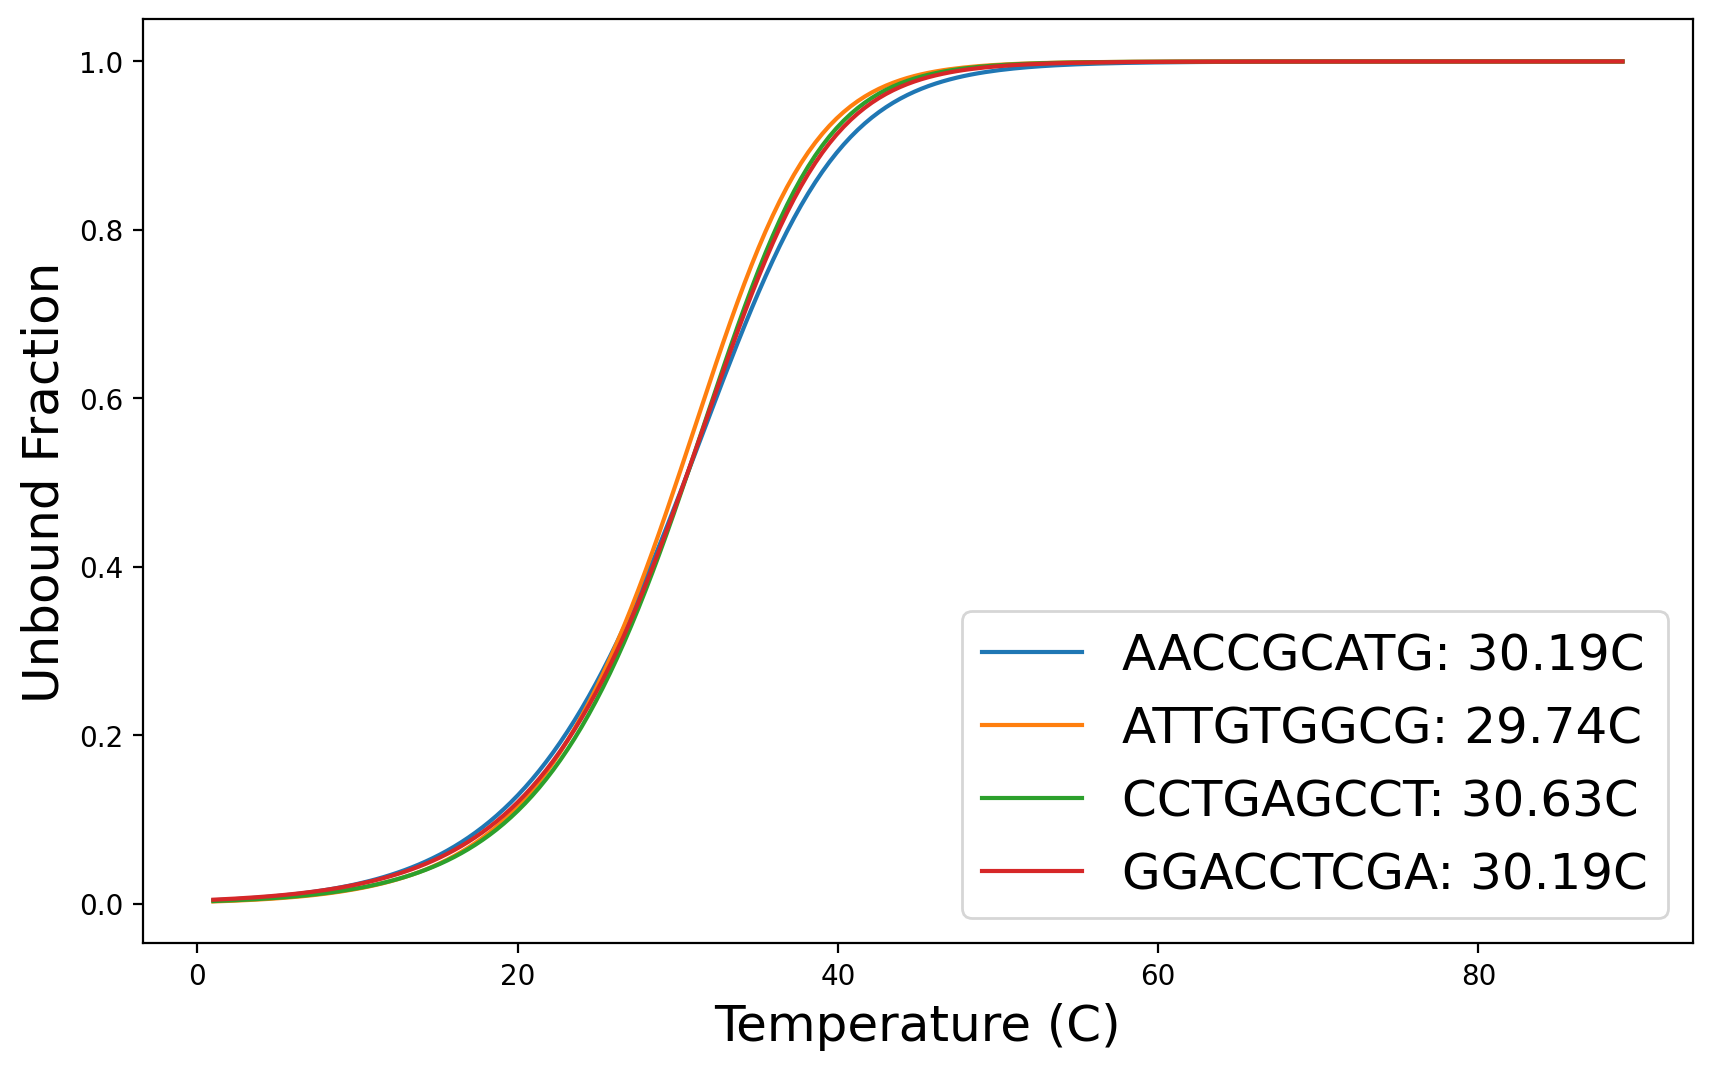

In [3]:
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq

#TTTTTTTTTTTTTTTTTTTTTT
myseqs_0  = [
'AACCGCATG',
'ATTGTGGCG',
'CCTGAGCCT',
'GGACCTCGA'
]
my_seqs_1 = [
'CATGCGGTT',
'CGCCACAAT',
'AGGCTCAGG',
'TCGAGGTCC'
]

temp_range = np.linspace(1,89,200)
melting_temperatures, unbound_fractions = compute_melting_temp(myseqs_0, temp_range=temp_range, c_seq=my_seqs_1)


plt.figure(figsize=(10,6), dpi=200)
for key, unbound_fraction in unbound_fractions.items():
    plt.plot(temp_range, unbound_fraction, label=f'{key}: {melting_temperatures[key]:.2f}C')
plt.legend(fontsize=18)
plt.xlabel('Temperature (C)', fontsize=18)
plt.ylabel('Unbound Fraction', fontsize=18)

In [39]:
from Bio.SeqUtils import MeltingTemp as mt
from Bio.Seq import Seq

myseqs  = [
"GGAGAGCGT",
"ACGGACTGC ",
"ACCGATGCT",
"GGTCCTGGC",
]

myseqs  = [
'TACAAGGCA',
'TGTTCTGGT',
'TGAGTGTGT',
'TACGCATCT',
]

# temp_range = np.linspace(1,60,300)
# melting_temperatures, unbound_fractions = compute_melting_temp(myseqs, temp_range=temp_range)

for myseq in myseqs:
    print(myseq)
    print('%0.2f' % mt.Tm_NN(myseq, dnac1=10, dnac2=10, 
                             Na=50, K=0, Tris=0, Mg=12.5, dNTPs=0, saltcorr=7))
    print('\n')

# plt.figure(figsize=(10,6), dpi=200)
# for key, unbound_fraction in unbound_fractions.items():
#     plt.plot(temp_range, unbound_fraction, label=f'{key}: {melting_temperatures[key]:.2f}')
# plt.legend()

TACAAGGCA
23.62


TGTTCTGGT
23.27


TGAGTGTGT
23.78


TACGCATCT
24.13




In [17]:
unbound_fractions

{'GGAGAGCGT': [np.float64(0.0017222750338986683),
  np.float64(0.002123499651452255),
  np.float64(0.002615488962853341),
  np.float64(0.0032180515231591236),
  np.float64(0.003955124306911372),
  np.float64(0.004855579252183588),
  np.float64(0.005954171280000676),
  np.float64(0.00729264717864036),
  np.float64(0.008921035072679669),
  np.float64(0.010899133893965162),
  np.float64(0.013298219022149076),
  np.float64(0.016202976383512698),
  np.float64(0.019713666349161833),
  np.float64(0.02394850583863774),
  np.float64(0.029046232432057884),
  np.float64(0.03516878125635165),
  np.float64(0.04250395641350513),
  np.float64(0.05126790992337515),
  np.float64(0.061707148477777626),
  np.float64(0.07409966391618489),
  np.float64(0.088754624583441),
  np.float64(0.10600986809160247),
  np.float64(0.12622620683436656),
  np.float64(0.14977731287827264),
  np.float64(0.17703372929115405),
  np.float64(0.2083394334595983),
  np.float64(0.2439794963944363),
  np.float64(0.284137928604478

In [19]:
melting_temperatures

{'GGAGAGCGT': np.float64(32.0),
 'GACACCCCC': np.float64(32.0),
 'ACCGATGCT': np.float64(32.0),
 'GGTCCTGGC': np.float64(32.0)}

In [13]:
from scipy.stats import linregress

# Perform linear regression on the Van't Hoff plot
slope, intercept, r_value, p_value, std_err = linregress(inverse_temp, ln_K_values)

# Calculate ΔH and ΔS from the slope and intercept
R = 1.987  # gas constant in cal/(mol*K)

delta_H = -slope * R  # ΔH in cal/mol
delta_S = intercept * R  # ΔS in cal/(mol*K)

print(f"ΔH = {delta_H:.2f} cal/mol")
print(f"ΔS = {delta_S:.2f} cal/(mol*K)")


ΔH = 39787.61 cal/mol
ΔS = 134.89 cal/(mol*K)


In [14]:
# Solve for T_m (K = 1, so ln(K) = 0)
T_m_kelvin = -slope / intercept

# Convert T_m from Kelvin to Celsius
T_m_celsius = T_m_kelvin - 273.15

print(f"Melting Temperature T_m = {T_m_celsius:.2f} °C")


Melting Temperature T_m = 21.82 °C
